## Sensitivity Analysis for Critical Distance

This jupyter notebook creates plots to study the impact of varying the critical distance for base-case analysis

### 0. Analysis IDs to compare

In [30]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (52, )

### 1. Package Installs

In [31]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [32]:
# Seaborn for plotting
#!pip install seaborn

In [33]:
# Plotly for plotting 
#!pip install plotly

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px

### 2. Environment Variables

In [35]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [36]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'chargeval_dev'

### 3. Database connection

In [37]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [38]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [39]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [40]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(44934,)

In [41]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id order by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

,count,analysis_id
0,618,359
1,14425,360
2,9575,361
3,4530,362
4,2381,363
5,1537,364
6,1105,365
7,851,366
8,676,367
9,548,368


In [42]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id order by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

,count,analysis_id
0,9575,361
1,4527,362
2,2379,363
3,1533,364
4,1104,365
5,848,366
6,675,367
7,545,368
8,407,369


In [43]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id order by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

,count,analysis_id
0,3,362
1,2,363
2,4,364
3,1,365
4,3,366
5,1,367
6,3,368
7,2,369


In [44]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, ap.param_value as critical_dist
from ev_stranded est
         join (
    select param_value, analysis_id
    from analysis_params
    where param_id = 2) as ap
              on est.analysis_id = ap.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY critical_dist;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

,stranded_lat,stranded_lng,analysis_id,critical_dist
0,47.176090,-124.194081,369,100
1,47.421073,-119.333589,369,100
2,47.293536,-122.212371,362,30
3,47.987071,-122.103679,362,30
4,47.275492,-122.559222,362,30


In [45]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id order by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

,sum,analysis_id
0,362692.0,361
1,248475.0,362
2,176960.0,363
3,139850.0,364
4,118138.0,365
5,100038.0,366
6,87664.0,367
7,78009.0,368
8,64540.0,369


In [46]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id order by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

,count,analysis_id
0,501,361
1,556,362
2,580,363
3,577,364
4,571,365
5,550,366
6,494,367
7,472,368
8,381,369


In [47]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id order by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

,count,analysis_id
0,255,361
1,287,362
2,323,363
3,304,364
4,317,365
5,308,366
6,261,367
7,246,368
8,201,369


In [83]:
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       ap.param_value::INTEGER               as critical_dist
FROM evse_power_draw epd
         join (select param_value, analysis_id from analysis_params where param_id = 2) as ap
              on epd.analysis_id = ap.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
GROUP BY epd.simulation_ts, epd.analysis_id, ap.param_value
ORDER BY critical_dist, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,))
evse_util

,analysis_id,datetime,total_power,critical_dist
0,360,2019-07-01 08:00:46,0,10
1,360,2019-07-01 08:01:46,0,10
2,360,2019-07-01 08:02:46,0,10
3,360,2019-07-01 08:03:46,0,10
4,360,2019-07-01 08:04:46,0,10
...,...,...,...,...
8647,369,2019-07-01 22:28:46,0,100
8648,369,2019-07-01 22:29:46,0,100
8649,369,2019-07-01 22:30:46,0,100
8650,369,2019-07-01 22:31:46,0,100


In [75]:
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       ap.param_value::INTEGER,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         join (select param_value, analysis_id from analysis_params where param_id = 2) as ap
              on ets.analysis_id = ap.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         left outer join (select coalesce(count(veh_id), 0) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
group by ets.analysis_id, ap.param_value, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
order by analysis_id;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,))
count_stats

,sim_count,analysis_id,param_value,fin_count,evmt,str_count,cs_count,wait_count
0,9575,361,20,9575,362692.0,NaN,501,255
1,4530,362,30,4527,248475.0,3.0,556,287
2,2381,363,40,2379,176960.0,2.0,580,323
3,1537,364,50,1533,139850.0,4.0,577,304
4,1105,365,60,1104,118138.0,1.0,571,317
5,851,366,70,848,100038.0,3.0,550,308
6,676,367,80,675,87664.0,1.0,494,261
7,548,368,90,545,78009.0,3.0,472,246
8,409,369,100,407,64540.0,2.0,381,201


In [76]:
count_stats.dtypes
# count_stats = count_stats.sort_values(by=['param_value'])
count_stats

,sim_count,analysis_id,param_value,fin_count,evmt,str_count,cs_count,wait_count
0,9575,361,20,9575,362692.0,NaN,501,255
1,4530,362,30,4527,248475.0,3.0,556,287
2,2381,363,40,2379,176960.0,2.0,580,323
3,1537,364,50,1533,139850.0,4.0,577,304
4,1105,365,60,1104,118138.0,1.0,571,317
5,851,366,70,848,100038.0,3.0,550,308
6,676,367,80,675,87664.0,1.0,494,261
7,548,368,90,545,78009.0,3.0,472,246
8,409,369,100,407,64540.0,2.0,381,201


In [77]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       ap.param_value::INTEGER,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         join (select param_value, analysis_id from analysis_params where param_id = 2) as ap
              on (lai.row_data -> 'analysis_id')::int = ap.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
order by lau.aid
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,param_value,time_taken_tripgen,time_taken_eviabm
0,2021-02-03 02:37:12.395885+00:00,361,2021-02-03 03:24:00.163996+00:00,2021-02-06 05:58:26.687895+00:00,# EV: 9575,20,46.0,4474.0
1,2021-02-03 02:37:15.546909+00:00,362,2021-02-03 03:10:26.256559+00:00,2021-02-03 21:14:56.450271+00:00,# EV: 4530,30,33.0,1084.0
2,2021-02-03 02:37:18.706435+00:00,363,2021-02-03 03:02:51.569619+00:00,2021-02-03 10:05:52.988490+00:00,# EV: 2381,40,25.0,423.0
3,2021-02-03 02:37:21.854548+00:00,364,2021-02-03 02:59:03.651090+00:00,2021-02-03 07:04:09.452483+00:00,# EV: 1537,50,21.0,245.0
4,2021-02-03 02:37:25.007118+00:00,365,2021-02-03 02:56:59.599018+00:00,2021-02-03 06:15:55.968421+00:00,# EV: 1105,60,19.0,198.0
5,2021-02-03 02:37:28.158541+00:00,366,2021-02-03 02:55:31.155098+00:00,2021-02-03 05:21:22.307142+00:00,# EV: 851,70,18.0,145.0
6,2021-02-03 02:37:31.308379+00:00,367,2021-02-03 02:54:01.363836+00:00,2021-02-03 05:03:23.842536+00:00,# EV: 676,80,16.0,129.0
7,2021-02-03 02:37:34.468692+00:00,368,2021-02-03 02:52:44.419107+00:00,2021-02-03 04:46:45.214498+00:00,# EV: 548,90,15.0,114.0
8,2021-02-03 02:37:37.646725+00:00,369,2021-02-03 02:50:54.951089+00:00,2021-02-03 04:19:52.148228+00:00,# EV: 409,100,13.0,88.0


### 5. Plotting

#### 5.1 Vehicle Counts

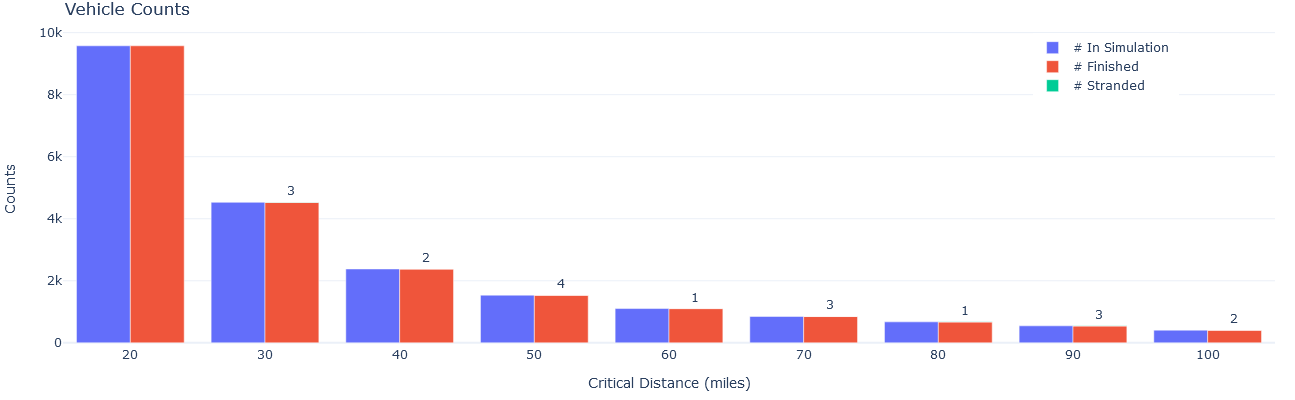

In [91]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# In Simulation",
            x=count_stats['param_value'],
            y=count_stats['sim_count'],
            offsetgroup=0,
            # text=count_stats['sim_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Finished",
            x=count_stats['param_value'],
            y=count_stats['fin_count'],
            offsetgroup=1,
            # text=count_stats['fin_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Stranded",
            x=count_stats['param_value'],
            y=count_stats['str_count'],
            offsetgroup=1,
            base=count_stats['fin_count'],
            text=count_stats['str_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Vehicle Counts",
        yaxis_title="Counts", 
        xaxis_title="Critical Distance (miles)", width=600, height=400
        
    )
)
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', legend=dict(
    # yanchor="top",
    y=0.99,
    # xanchor="right",
    x=0.8
))
fig.show()

#### 5.2 eVMT

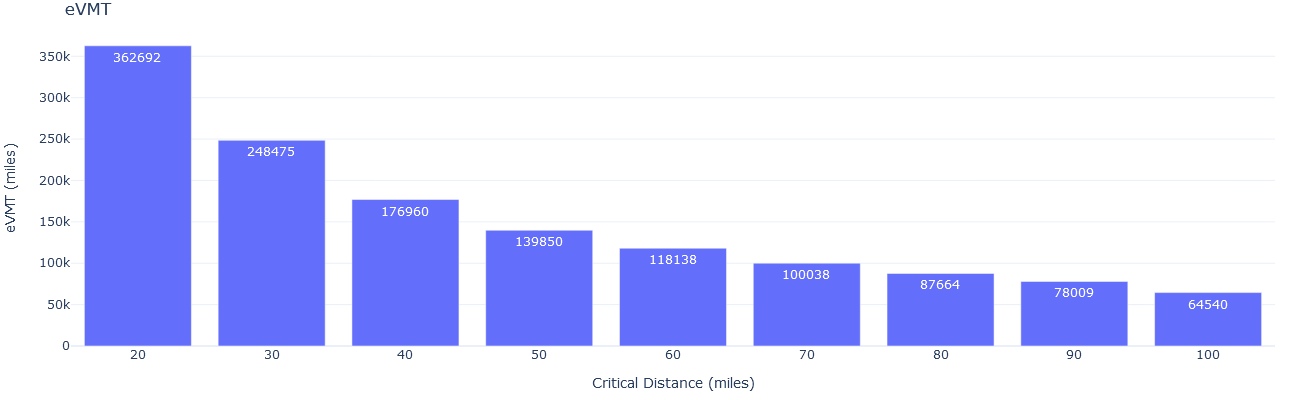

In [86]:
fig = go.Figure(
    data=[
        go.Bar(
            name="eVMT",
            x=count_stats['param_value'],
            y=count_stats['evmt'],
            offsetgroup=1,
            text=count_stats['evmt'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="eVMT",
        yaxis_title="eVMT (miles)", 
        xaxis_title="Critical Distance (miles)", uniformtext_minsize=8, uniformtext_mode='hide', width=400, height=400
        
    )
)
fig.update_xaxes(type='category')

fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.3 Charging and Waiting Sessions

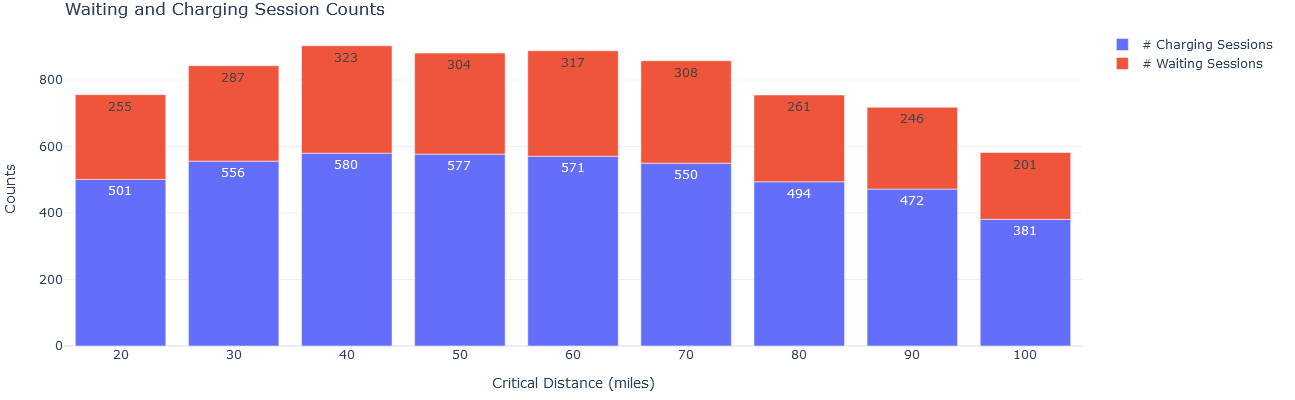

In [80]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# Charging Sessions",
            x=count_stats['param_value'],
            y=count_stats['cs_count'],
            offsetgroup=1,
            text=count_stats['cs_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Waiting Sessions",
            x=count_stats['param_value'],
            y=count_stats['wait_count'],
            offsetgroup=1,
            base=count_stats['cs_count'],
            text=count_stats['wait_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Waiting and Charging Session Counts",
        yaxis_title="Counts", 
        xaxis_title="Critical Distance (miles)", width=600, height=400
        
    )
)
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.4 EVSE Utilization

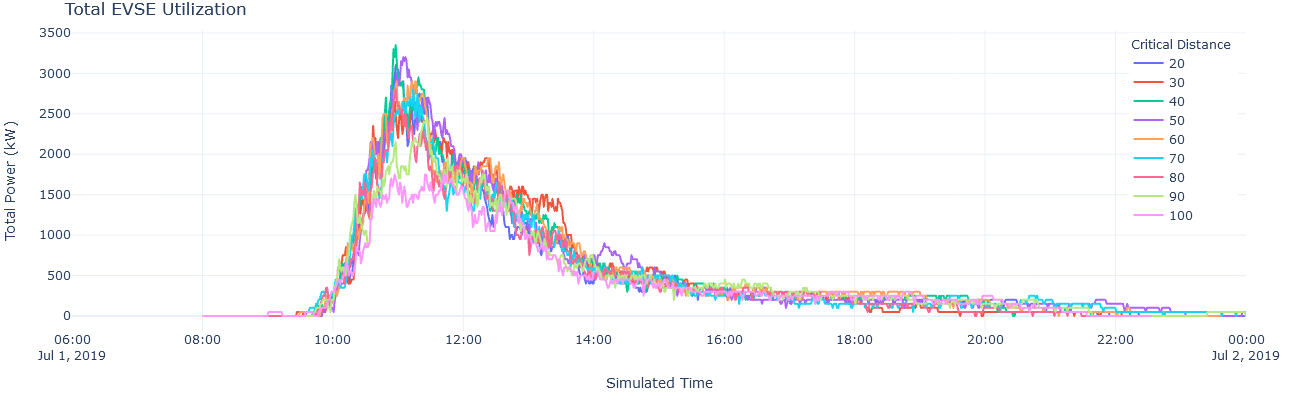

In [94]:
fig = px.line(evse_util[evse_util['critical_dist'] > 10], x="datetime", y="total_power", color='critical_dist', labels={"critical_dist": 'Critical Distance'}, range_x=['2019-07-01 06:00','2019-07-02'])
fig.update_layout(title="Total EVSE Utilization",
                  yaxis_title="Total Power (kW)", 
                  xaxis_title="Simulated Time", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=1000, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20), template='plotly_white', legend=dict(
    # yanchor="top",
    y=0.99,
    # xanchor="right",
    x=0.9
)
                  )
fig.show()

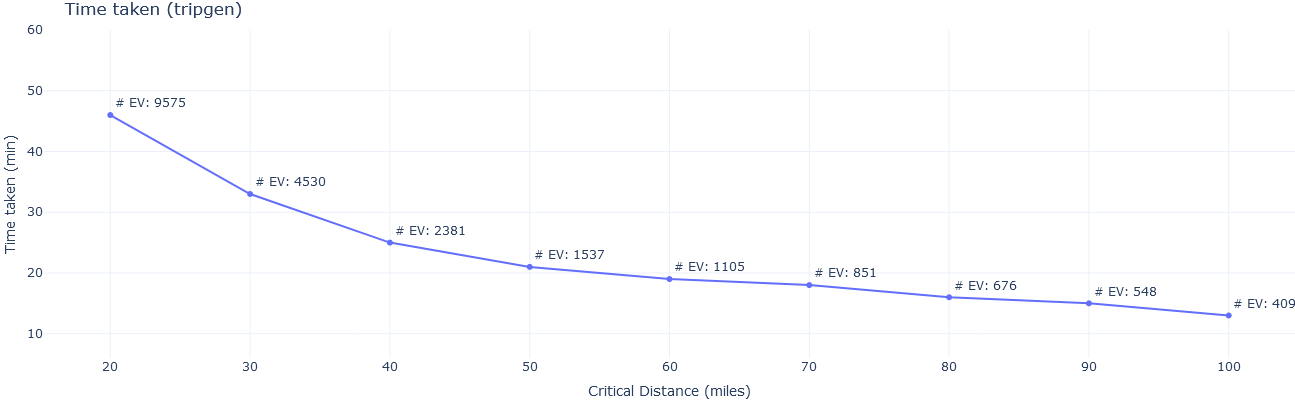

In [56]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_tripgen'],
                         mode='lines+markers+text',
                         name='lines+markers', 
                         text=comp_stats['ev_count'],
                         textposition="top right"))
fig.update_xaxes(type='category', automargin=True)
fig.update_yaxes(range=(6, 60))
fig.update_layout(title="Time taken (tripgen)",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Critical Distance (miles)", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=400, 
                  height=400, 
                  margin=dict(l=20, r=0, t=30, b=20),
                 template='plotly_white')
fig.show()

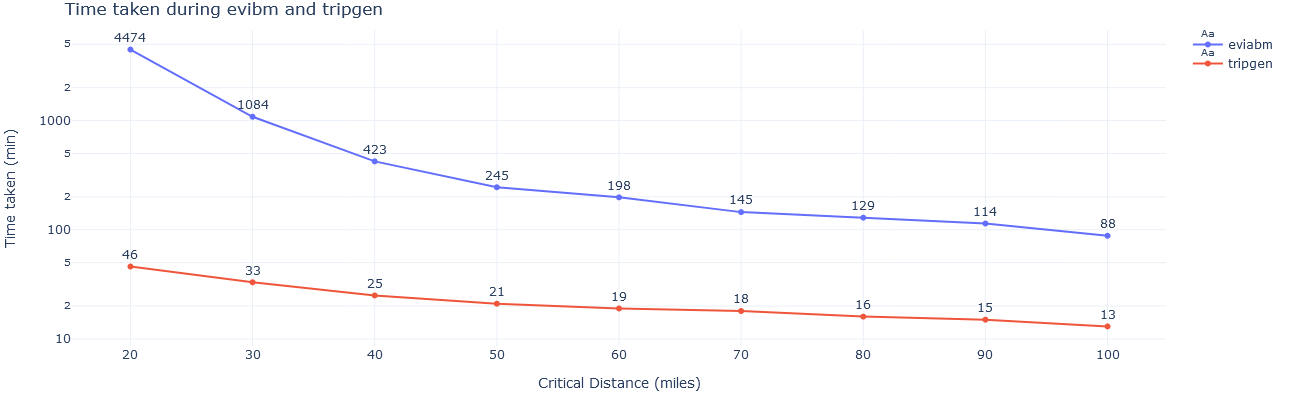

In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_eviabm'],
                    mode='lines+markers+text',
                    name='eviabm', text=comp_stats['time_taken_eviabm'],
                    textposition="top center"))
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_tripgen'],
                         mode='lines+markers+text',
                         name='tripgen', text=comp_stats['time_taken_tripgen'],
                         textposition="top center"))
fig.update_xaxes(type='category')
fig.update_yaxes( type="log")
fig.update_layout(title="Time taken during evibm and tripgen",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Critical Distance (miles)", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=600, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20),
                  template='plotly_white')
fig.show()

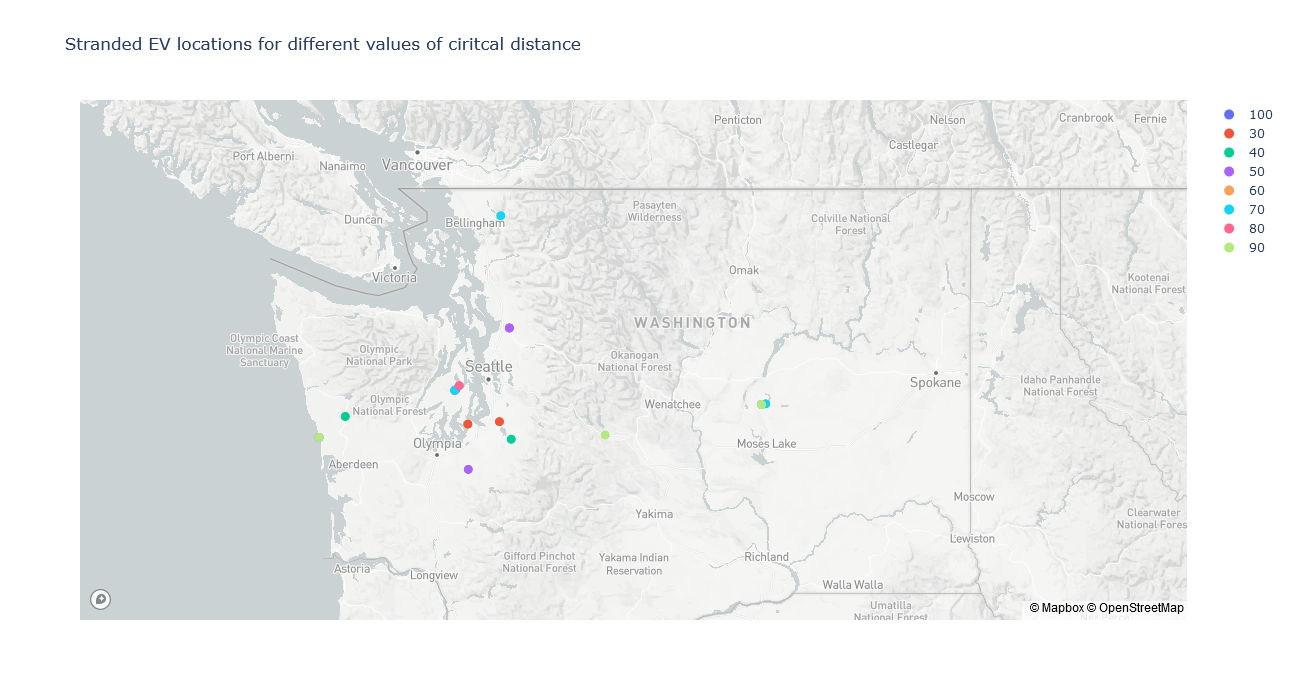

In [58]:
fig = go.Figure()
token = os.getenv("MAPBOX_ACCESS_TOKEN")
for seed in evs_str_loc['critical_dist'].unique():
    fig.add_trace(go.Scattermapbox(
            lat=evs_str_loc[evs_str_loc['critical_dist'] == seed]['stranded_lat'],
            lon=evs_str_loc[evs_str_loc['critical_dist'] == seed]['stranded_lng'],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=10
            ), 
            name = seed
        ))

fig.update_layout(
        title_text = 'Stranded EV locations for different values of ciritcal distance',
        showlegend = True,
        mapbox_style="light", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700
    )

fig.show()

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [59]:
#!jupyter labextension list

In [60]:
#!jupyter labextension uninstall jupyterlab-plotly

In [61]:
#!jupyter labextension uninstall plotlywidget

In [62]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [63]:
#!pip show plotly

In [64]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [65]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [66]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [67]:
#!pip install "nbconvert<6"